# Comparison of various ML models for normal/pd gait classification

In [1]:
# Essential libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
%cd ..
from google.colab import drive
drive.mount('./content/gdrive')

/
Mounted at ./content/gdrive


In [3]:
DATADIR = "/content/gdrive/MyDrive/Gait_analysis/all_fixed/data_150"

In [4]:
DATADIR

'/content/gdrive/MyDrive/Gait_analysis/all_fixed/data_150'

In [5]:
# List of categories

# 0 for abnormal masks
# 1 for normal masks

CATEGORIES = ["normal_resized150", "abnormal_resized150"]

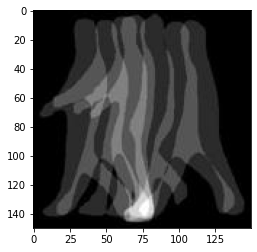

In [6]:
# to read and show one image from the datadir and joining its path to the category

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap = "gray")
        plt.show()
        break
    break 

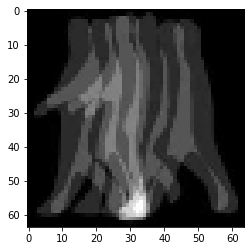

In [7]:
# All images should be 64 X 64 size, although all of them are, but just incase.

IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = "gray")
plt.show()

In [8]:
# To make the training data and labels from the datadir and categories

training_data = []
labels = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            #try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append(new_array)
            
            if "abnormal_resized150" in category:
                labels.append(0)
            else:
                labels.append(1)
           # except Exception as e:
            #    pass

create_training_data()

In [9]:
len(training_data)

276

In [10]:
# Reshaping the images as 1D array because the model takes images
# as 1D array. Also made the labels a numpy array.

X = np.array(training_data).reshape(len(training_data), 4096).astype(float)
y = np.array(labels)

In [11]:
print(X.shape)
print(y.shape)

(276, 4096)
(276,)


# Machine learning algorithms

In [12]:
from sklearn.svm import SVC
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [13]:
# Split for train and test from the training_data and labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=0)

In [14]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

193
193
83
83


In [15]:
# Make a pipeline for Support vector machine

SupportVector = Pipeline([("scaler" , StandardScaler()), ("svc", SVC(kernel = "rbf", C = 10))])

In [16]:
# Fit and check the accuracy with score

SupportVector.fit(X_train, y_train)
SupportVector.score(X_test, y_test)

0.9879518072289156

In [17]:
# predict with the trained model 

labels = ["abnormal gait","normal gait"]
sample_image = X_test[6]
sample_label = y_test[6]
SupportVector.predict([sample_image])

array([1])

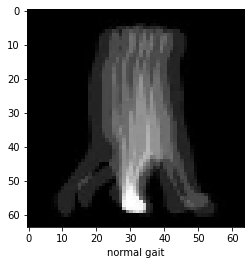

In [18]:
# To see the predicted image, we need to change the 1D array to 2D array

example = np.reshape(sample_image, (64, 64))
plt.imshow(example, cmap = "gray")
plt.xlabel(labels[sample_label])
plt.show()

In [19]:
y_predicted = SupportVector.predict(X_test)
y_predicted

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [20]:
# Classification report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.97      1.00      0.99        39

    accuracy                           0.99        83
   macro avg       0.99      0.99      0.99        83
weighted avg       0.99      0.99      0.99        83



In [21]:
# Grid SearchCV to find the best parameters for all the 

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [22]:
# defining a list of parameters for every machine learning algorithm

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear', 'sigmoid', 'poly']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10,50]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10,50]
    #     }
    # },
    # 'decision_tree':{
    #     'model' : tree.DecisionTreeClassifier(),
    #     'params': {
    #     'dt__criterion': ['entropy', 'gini'],
    #     'dt__max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
        }
    }
}


In [23]:
# This will give the best parameters with every algorithm 

scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

model  best_score  \
0                  svm    0.979352   
1        random_forest    0.937787   
2  logistic_regression    0.974359   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 50}  
2                 {'logisticregression__C': 50}

In [24]:
# Lets check the accuracy of every model above with the test dataset

print("The accuracy of Support Vector Machine is:", best_estimators["svm"].score(X_test, y_test))
print("The accuracy of Random Forest is:", best_estimators["random_forest"].score(X_test, y_test))
print("The accuracy of Logistic Regression is:", best_estimators["logistic_regression"].score(X_test, y_test))

The accuracy of Support Vector Machine is: 1.0
The accuracy of Random Forest is: 1.0
The accuracy of Logistic Regression is: 1.0


In [25]:
# saving the models in the following variables 

clf1 = best_estimators["svm"]
clf2 = best_estimators["random_forest"]
clf3 = best_estimators["logistic_regression"]

In [26]:
# Let's view the confusion matrix

from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, clf1.predict(X_test))
cm1

array([[44,  0],
       [ 0, 39]])

In [28]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test, clf2.predict(X_test))
cm2

array([[44,  0],
       [ 0, 39]])

In [29]:
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test, clf3.predict(X_test))
cm3

array([[44,  0],
       [ 0, 39]])

Text(15.0, 0.5, 'Truth')

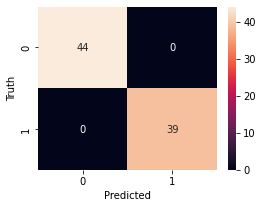

In [31]:
# Let's view a more asthetic confusion matrix

import seaborn as sn
plt.figure(figsize = (4, 3))
sn.heatmap(cm3, annot= True)
plt.xlabel("Predicted")
plt.ylabel("Truth")